In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import transform_strokes, inverse_transform_strokes, get_n_points
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.plot import get_canvas, plot, get_animation
from lib.model import Decoder
from lib.model import train, evaluate, reconstruction_loss
from lib.model import extract_start_of_stroke, generate

# Load and show dataset

In [52]:
dataset_name = 'cat'

In [53]:
dataset = unpack_drawings(f'./data/{dataset_name}.bin')
dataset = list(dataset)

In [54]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

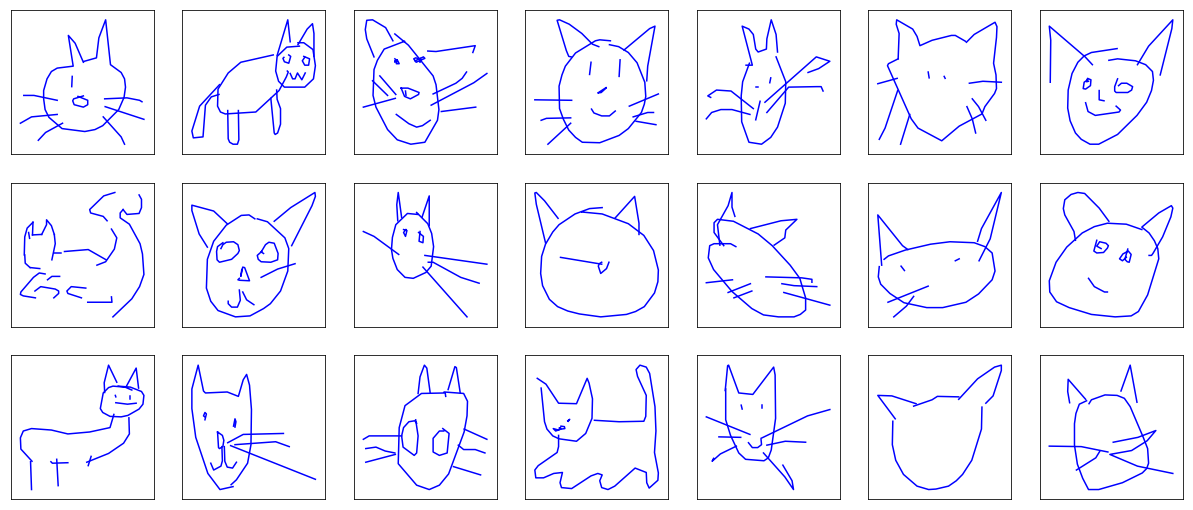

In [55]:
fig, axarr = get_canvas(3, 7)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

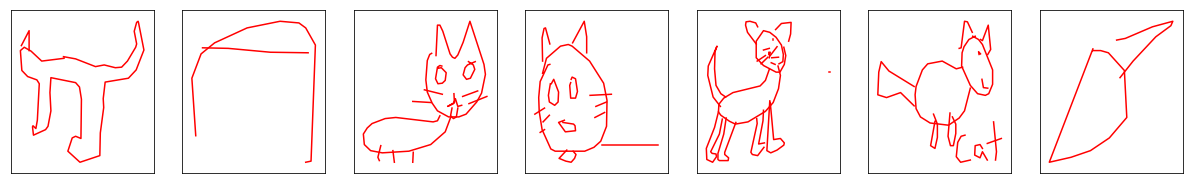

In [56]:
fig, axarr = get_canvas(1, 7)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [57]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [58]:
HTML(anim.to_html5_video())

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'delta_y')

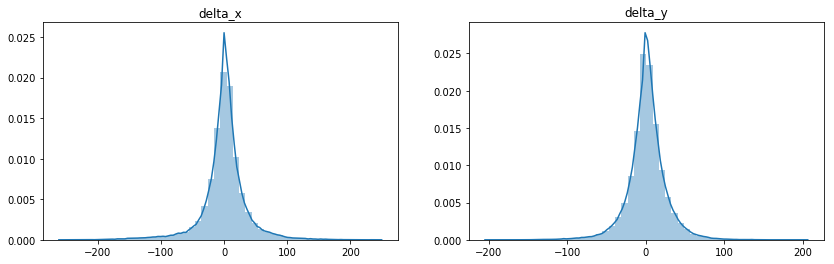

In [59]:
# Transformed stroke coordinates follow a gaussian distribution.

transformed_drawings = [transform_strokes(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

# Create pytorch dataset

In [60]:
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transform_strokes(drawing) for drawing in drawings]

In [61]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [62]:
ds = get_dataset(transformed_drawings)

In [66]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.15)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(11604, 3743)

In [67]:
train_means_stds = get_means_stds(train_ds)
val_means_stds = get_means_stds(val_ds)

In [68]:
# Debug batches generation

train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lengths_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lengths_batch):
    print(tensor)
    print()

torch.Size([173, 2, 5]) torch.Size([173, 2, 5]) torch.Size([2])


tensor([[[ 0.2350,  1.7298,  1.0000,  0.0000,  0.0000],
         [-0.7692,  0.8434,  1.0000,  0.0000,  0.0000]],

        [[-0.0161,  0.0376,  1.0000,  0.0000,  0.0000],
         [-0.6297,  1.3269,  1.0000,  0.0000,  0.0000]],

        [[-0.0997, -0.2444,  1.0000,  0.0000,  0.0000],
         [ 1.1275, -2.1380,  0.0000,  1.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0')

tensor([[[-0.0161,  0.0376,  1.0000,  0.0000,  0.0000],
         [-0.6297,  1.3269,  1.0000,  0.0000,  0.0000]],

        [[-0.0997, -0.2444,  1.0000,  0.0000,  0.0000],
         [ 1.1275, -2.1380,  0.0000,  1.0000,  0

In [69]:
# Debug model forward

model = Decoder(dim_hidden=5, n_gaussians=3)

if torch.cuda.is_available():
    model = model.cuda()

train_batches = get_batches(train_ds, train_means_stds, batch_size=1024)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

gmm_params, strokes_state_params, lstm_states = model(data_batch, lengths_batch)

In [70]:
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
hidden_state, cell_state = lstm_states

print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)

print(strokes_state_params.shape)

print(hidden_state.shape, cell_state.shape)

torch.Size([169, 1024, 3])
torch.Size([169, 1024, 3]) torch.Size([169, 1024, 3])
torch.Size([169, 1024, 3]) torch.Size([169, 1024, 3]) torch.Size([169, 1024, 3])
torch.Size([169, 1024, 3])
torch.Size([1, 1024, 5]) torch.Size([1, 1024, 5])


In [71]:
# Debug loss
reconstruction_loss(gmm_params, strokes_state_params, labels_batch, lengths_batch)

tensor(3.8149, device='cuda:0', grad_fn=<ThAddBackward>)

In [72]:
# Debug generation
start_of_stroke = extract_start_of_stroke(train_ds, n_points=2)
generate(model, start_of_stroke, n_points=3)

tensor([[-0.1834,  1.7700,  1.0000,  0.0000,  0.0000],
        [ 0.7091, -1.2516,  1.0000,  0.0000,  0.0000],
        [-0.1971,  0.1955,  0.0000,  0.0000,  1.0000],
        [-1.2342,  1.7016,  0.0000,  0.0000,  1.0000],
        [-0.4937,  0.6070,  0.0000,  0.0000,  1.0000]], device='cuda:0')

# Train

In [73]:
batch_size = 64
dim_hidden = 128
n_gaussians = 20

model = Decoder(dim_hidden, n_gaussians)
if torch.cuda.is_available():
    model = model.cuda()

criterion = reconstruction_loss
optimizer = Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [74]:
print(model)

Decoder(
  (lstm): LSTM(5, 128)
  (output_weights): Linear(in_features=128, out_features=123, bias=True)
)


In [75]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=300, epochs_between_evals=10)

epoch:   1   train_loss: 2.54615   val_loss: 2.54670
epoch:  10   train_loss: 1.59666   val_loss: 1.61696
epoch:  20   train_loss: 1.40336   val_loss: 1.43627
epoch:  30   train_loss: 1.29465   val_loss: 1.33916
epoch:  40   train_loss: 1.23362   val_loss: 1.29090
epoch:  50   train_loss: 1.18126   val_loss: 1.25578
epoch:  60   train_loss: 1.15019   val_loss: 1.23676
epoch:  70   train_loss: 1.12415   val_loss: 1.22022
epoch:  80   train_loss: 1.10151   val_loss: 1.20958
epoch:  90   train_loss: 1.07939   val_loss: 1.19985
epoch: 100   train_loss: 1.06808   val_loss: 1.19760
epoch: 110   train_loss: 1.06198   val_loss: 1.20544
epoch: 120   train_loss: 1.01992   val_loss: 1.17677
Epoch   126: reducing learning rate of group 0 to 1.0000e-04.
epoch: 130   train_loss: 0.86902   val_loss: 1.05328
epoch: 140   train_loss: 0.85321   val_loss: 1.05756
Epoch   142: reducing learning rate of group 0 to 1.0000e-05.
epoch: 150   train_loss: 0.82424   val_loss: 1.06222
Epoch   154: reducing learni

KeyboardInterrupt: 

In [79]:
torch.save(model.state_dict(), f'models/{dataset_name}.pth')

# Predict

In [80]:
model_name = dataset_name
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(f'./models/{dataset_name}.pth', map_location=map_location))

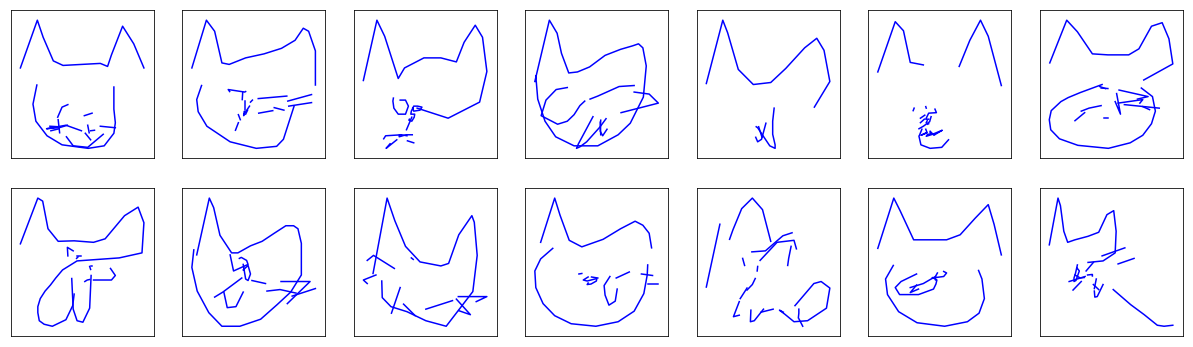

In [91]:
temperature = 1.0

fig, axarr = get_canvas(2, 7)

start_of_stroke = extract_start_of_stroke(val_ds, n_points=1)

if torch.cuda.is_available():
    start_of_stroke = start_of_stroke.cuda()

all_preds_strokes = []
for i, ax in enumerate(axarr.flatten()):
    pred_flat_strokes = generate(model, start_of_stroke, n_points=50, temperature=temperature)
    pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
    pred_strokes = inverse_transform_strokes(pred_flat_strokes)
    all_preds_strokes.append(pred_strokes)
    plot(pred_strokes, color='b', ax=ax)

In [92]:
%%capture
pred_anim = get_animation(all_preds_strokes[0])

In [93]:
# Generated drawing
HTML(pred_anim.to_html5_video())

In [ ]:
pred_anim.save('generated.gif', dpi=80, writer='imagemagick')